In [13]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

from qiskit_aer import AerSimulator

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

shots = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)

In [14]:
print(num_qubits)

4


In [15]:
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, pauli_error

def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

noise_model=get_noise(0.01)

#TO DO : generalize for different p for each qubit (if needed. Might very well be the case that experimentally all qubits are equivalent)

# Step 2: Configure the AerSimulator with the custom noise model
backend = AerSimulator(noise_model=noise_model)

In [16]:
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


In [17]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
mitigator = result.analysis_results("Local Readout Mitigator").value

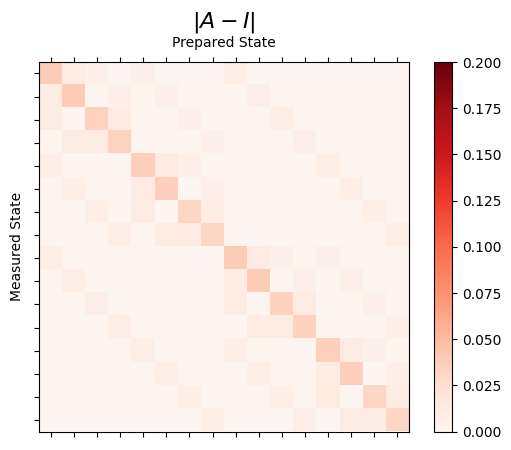

In [18]:
result.figure(0)


In [19]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.01097804 -0.01097804]
 [-0.01097804  1.01097804]]

[[ 1.01092354 -0.00595829]
 [-0.01092354  1.00595829]]

[[ 1.00892857 -0.00694444]
 [-0.00892857  1.00694444]]

[[ 1.00894632 -0.00894632]
 [-0.00894632  1.00894632]]



In [21]:
#define a new random circuit
qc = QuantumCircuit(num_qubits)
qc.sx(0)
for i in range(1, num_qubits):
    qc.cx(i - 1, i)
print(qc)
qc.measure_all()
counts = backend.run(qc, shots=shots, seed_simulator=42, method="density_matrix").result().get_counts()
unmitigated_probs = {label: count / shots for label, count in counts.items()}

mitigated_quasi_probs = mitigator.quasi_probabilities(counts) #apply the mitigator to the counts of the new circuit
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities()) #convert quasi_probabilities into probabilities

     ┌────┐               
q_0: ┤ √X ├──■────────────
     └────┘┌─┴─┐          
q_1: ──────┤ X ├──■───────
           └───┘┌─┴─┐     
q_2: ───────────┤ X ├──■──
                └───┘┌─┴─┐
q_3: ────────────────┤ X ├
                     └───┘


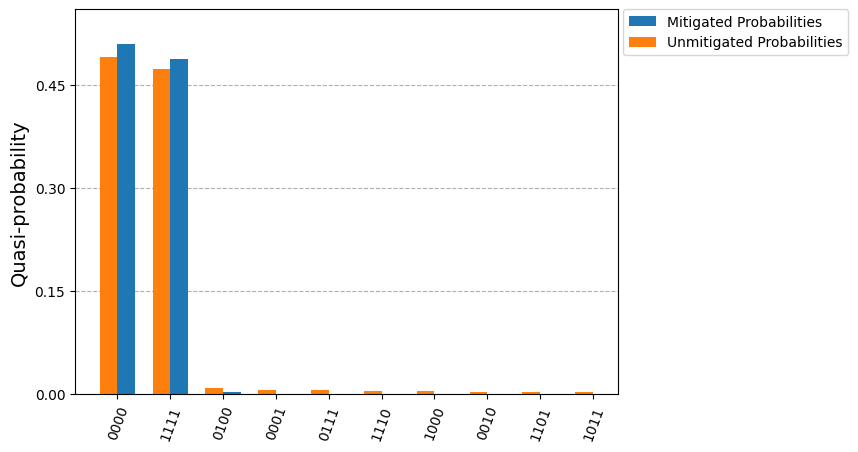

In [22]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_distribution([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

[array([ 1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
       -1., -1.,  1.]), array([ 1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1.,  1.]), array([ 1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1.]), array([ 0.,  0., -0., -0., -0., -0.,  0.,  0.,  1.,  0., -1., -0., -1.,
       -0.,  1.,  0.])]


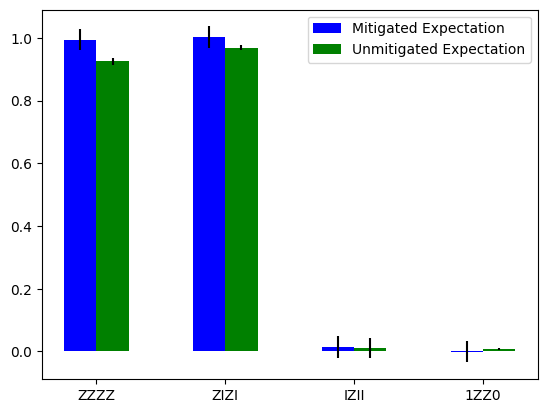

In [23]:
diagonal_labels = ["ZZZZ", "ZIZI", "IZII", "1ZZ0"]
ideal_expectation = [] # is the ideal expectation the one where <psi|O|psi> and |psi> is the state of the circuit at the end?
diagonals = [str2diag(d) for d in diagonal_labels] # don't we expect 16*16 matrices
print(diagonals)
qubit_index = {i: i for i in range(num_qubits)}
unmitigated_probs_vector, _ = counts_probability_vector(unmitigated_probs, qubit_index=qubit_index)
unmitigated_expectation = [expval_with_stddev(d, unmitigated_probs_vector, shots) for d in diagonals]
mitigated_expectation = [mitigator.expectation_value(counts, d) for d in diagonals] #where is this function implemented?
mitigated_expectation_values, mitigated_stddev = zip(*mitigated_expectation)
unmitigated_expectation_values, unmitigated_stddev = zip(*unmitigated_expectation)
legend = ['Mitigated Expectation', 'Unmitigated Expectation']
fig, ax = plt.subplots()
X = np.arange(4)
ax.bar(X + 0.00, mitigated_expectation_values, yerr=mitigated_stddev, color='b', width = 0.25, label="Mitigated Expectation")
ax.bar(X + 0.25, unmitigated_expectation_values, yerr=unmitigated_stddev, color='g', width = 0.25, label="Unmitigated Expectation")
ax.set_xticks([0.125 + i for i in range(len(diagonals))])
ax.set_xticklabels(diagonal_labels)
ax.legend()

In [11]:
#TO DO : if needed, repeat the whole process with a correlated readout error model

qubits = [0,3]
num_qubits = len(qubits)
exp = CorrelatedReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
